# MNIST on Kaggle

Kyle Horn - April 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

## 1. Introduction

MNIST is a classic benchmarking problem in machine learning. At this point, it's so old that it may actually be an antiquated benchmark, even for introductory tutorials. Here I demonstrate a simple deep CNN approach with parameter tuning, as part of preparing for more difficult Kaggles. The contest and associated interesting reading materials are as follows:

* https://www.kaggle.com/c/digit-recognizer
* https://www.kaggle.com/c/digit-recognizer/discussion/61480
* https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
* https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist
* https://keras.io/examples/mnist_cnn/ - Since MNIST is used for benchmarking, it shouldn't be a surprise that the makers of Keras would have a sample solution in their docs.

### 1.a Data

The training and test data are distributed by Kaggle in a singular, bulk csv file. Here I clean it up with a few simple lines of code:

In [2]:
img_shape = (28,28)

train_data = pd.read_csv("./train.csv")
train_labels = train_data['label'].values
train_images = train_data.drop('label',axis='columns').values.reshape(-1,img_shape[0],img_shape[1])

test_data = pd.read_csv("./test.csv")
test_images = test_data.values.reshape(-1,img_shape[0],img_shape[1])

Next I visualize the data, to ensure I've munged it correctly. I could set it to black and white, but the Matplotlib default color scheme is more fun:

A few training images (with labels)


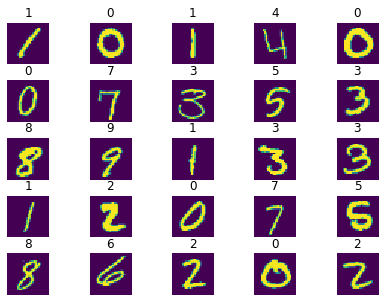

In [3]:
print("A few training images (with labels)")
plt.figure()
for i in range(5):
    for j in range(5):
        k = i+j*5
        plt.subplot(5,5,k+1)
        plt.title(str(train_labels[k]))
        plt.axis('off')
        plt.imshow( train_images[k] )
plt.tight_layout(0)
plt.show()

A few test images


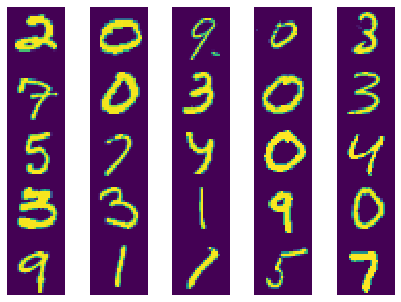

In [4]:
print("A few test images")
plt.figure()
for i in range(5):
    for j in range(5):
        k = i+j*5
        plt.subplot(5,5,k+1)
        plt.axis('off')
        plt.imshow( test_images[k] )
plt.tight_layout(0)
plt.show()

## 2. Simple Deep CNN

### 2.a Keras Docs Version

#### 2.a.1 Imported MNIST Data

I begin by lifting the code for MNIST from the Keras documentation. They claim to get a 99.25% test accuracy in 12 epochs (with a total wall time of 3.2 minutes, on a GRID K520 GPU). I'm seeing closer a test accuracy of 84% over 12.3 minutes on my i7-7700K. The time should be slower, but not the accuracy; that's pretty terrible, but an ok place to start. When increasing the number of epochs to 120, I get ~94% accuracy, which still isn't terribly good.

It should be noted that I'm using keras from within TensorFlow2, and the imports had to be modified. I dont know if the affected performance. I kept Keras' MNIST data import, rather than use Kaggle's data, just to verify their test accuracy claim.

The code is below:

In [5]:
from __future__ import print_function
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow import keras

batch_size = 128
num_classes = 10
epochs = 120#12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
                    #shuffle=True)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/120
60000/60000 [==============================] - 66s 1ms/sample - loss: 2.2867 - accuracy: 0.1437 - val_loss: 2.2479 - val_accuracy: 0.4543
Epoch 2/120
60000/60000 [==============================] - 70s 1ms/sample - loss: 2.2250 - accuracy: 0.2700 - val_loss: 2.1722 - val_accuracy: 0.6080
Epoch 3/120
60000/60000 [==============================] - 65s 1ms/sample - loss: 2.1452 - accuracy: 0.3880 - val_loss: 2.0714 - val_accuracy: 0.6730
Epoch 4/120
60000/60000 [==============================] - 66s 1ms/sample - loss: 2.0372 - accuracy: 0.4707 - val_loss: 1.9343 - val_accuracy: 0.7128
Epoch 5/120
60000/60000 [==============================] - 65s 1ms/sample - loss: 1.8956 - accuracy: 0.5246 - val_loss: 1.7526 - val_accuracy: 0.7435
Epoch 6/120
60000/60000 [==============================] - 66s 1ms/sample - loss: 1.7207 - accuracy: 0.5713 - val_loss: 1.5344 

60000/60000 [==============================] - 68s 1ms/sample - loss: 0.3207 - accuracy: 0.9050 - val_loss: 0.1962 - val_accuracy: 0.9423
Epoch 109/120
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.3224 - accuracy: 0.9039 - val_loss: 0.1954 - val_accuracy: 0.9427
Epoch 110/120
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.3224 - accuracy: 0.9053 - val_loss: 0.1947 - val_accuracy: 0.9431
Epoch 111/120
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.3183 - accuracy: 0.9064 - val_loss: 0.1933 - val_accuracy: 0.9440
Epoch 112/120
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.3154 - accuracy: 0.9062 - val_loss: 0.1925 - val_accuracy: 0.9436
Epoch 113/120
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.3145 - accuracy: 0.9072 - val_loss: 0.1919 - val_accuracy: 0.9430
Epoch 114/120
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.3147 - accuracy:

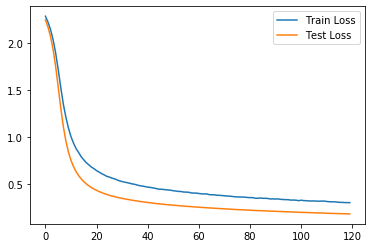

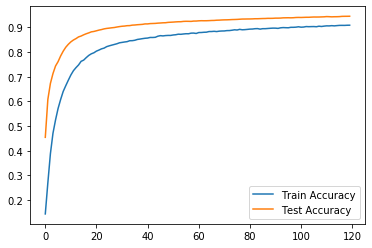

In [6]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss','Test Loss'])
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train Accuracy','Test Accuracy'])
plt.show()

#### 2.a.2 Kaggle Data

The previous code used Keras' built-in MNIST data. With Keras' basic benchmark code functioning, I can now work the Kaggle data in, and get a clearer sense of how this model performs. Below the Keras MNIST import is disabled, the code is cleaned up a little, and is re-run on Kaggle's data set. I also up the batch size.

In [7]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

batch_size = 256
num_classes = 10
epochs = 120

input_shape = (train_images.shape[1], train_images.shape[2], 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(train_images[:,:,:,None]/255., train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    shuffle=True)
                    #validation_data=(x_test, y_test))
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

Train on 37800 samples, validate on 4200 samples
Epoch 1/120
37800/37800 [==============================] - 41s 1ms/sample - loss: 2.2959 - accuracy: 0.1230 - val_loss: 2.2811 - val_accuracy: 0.2052
Epoch 2/120
37800/37800 [==============================] - 39s 1ms/sample - loss: 2.2790 - accuracy: 0.1587 - val_loss: 2.2624 - val_accuracy: 0.3343
Epoch 3/120
37800/37800 [==============================] - 39s 1ms/sample - loss: 2.2608 - accuracy: 0.2044 - val_loss: 2.2427 - val_accuracy: 0.4555
Epoch 4/120
37800/37800 [==============================] - 39s 1ms/sample - loss: 2.2427 - accuracy: 0.2443 - val_loss: 2.2213 - val_accuracy: 0.5276
Epoch 5/120
37800/37800 [==============================] - 40s 1ms/sample - loss: 2.2212 - accuracy: 0.2908 - val_loss: 2.1974 - val_accuracy: 0.5750
Epoch 6/120
37800/37800 [==============================] - 40s 1ms/sample - loss: 2.1982 - accuracy: 0.3321 - val_loss: 2.1703 - val_accuracy: 0.6045
Epoch 7/120
37800/37800 [==========================

Epoch 55/120
37800/37800 [==============================] - 39s 1ms/sample - loss: 0.6449 - accuracy: 0.7987 - val_loss: 0.4454 - val_accuracy: 0.8781
Epoch 56/120
37800/37800 [==============================] - 39s 1ms/sample - loss: 0.6384 - accuracy: 0.8030 - val_loss: 0.4406 - val_accuracy: 0.8786
Epoch 57/120
37800/37800 [==============================] - 39s 1ms/sample - loss: 0.6324 - accuracy: 0.8036 - val_loss: 0.4359 - val_accuracy: 0.8810
Epoch 58/120
37800/37800 [==============================] - 39s 1ms/sample - loss: 0.6290 - accuracy: 0.8034 - val_loss: 0.4315 - val_accuracy: 0.8814
Epoch 59/120
37800/37800 [==============================] - 39s 1ms/sample - loss: 0.6192 - accuracy: 0.8056 - val_loss: 0.4270 - val_accuracy: 0.8819
Epoch 60/120
37800/37800 [==============================] - 39s 1ms/sample - loss: 0.6138 - accuracy: 0.8096 - val_loss: 0.4226 - val_accuracy: 0.8819
Epoch 61/120
37800/37800 [==============================] - 40s 1ms/sample - loss: 0.6145 - ac

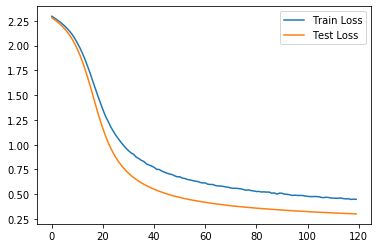

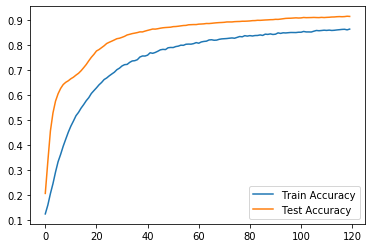

In [8]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss','Test Loss'])
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train Accuracy','Test Accuracy'])
plt.show()

This model hasn't actually completely converged, in terms of accuracy, but I'm moving on to a better model regardless. It should be noted that the number of epochs I'm using for this problem is a bit extreme.

### 2.b Deep CNN

From my prevoius barely-functional CNN code, I can begin expanding the model. As a best-practice, I'll evaluate a few historically significant architecture options from the literature. Here are some schematics for a few famous image-recognition Deep CNNs:
* https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d

And here are a few supplemental papers and pages on some of them:
* Deep Residual Learning for Image Recognition (He et al 2015) https://arxiv.org/pdf/1512.03385.pdf
* Densely Connected Convolutional Networks (Huang et al 2018) https://arxiv.org/pdf/1608.06993.pdf
* Going Deeper with Convolutions (Szegedy et al 2014) https://arxiv.org/pdf/1409.4842.pdf
* VGG-19 Pre Train (For transfer learning) https://www.kaggle.com/keras/vgg19

Notice that my last link above is to a pre-trained model. One of the easiest ways to start on a production-ready deep learning model is to begin from a heavy-duty pre-trained model (which forms the basis of "transfer learning"). These are generally extensively trained by teams of experts on massive data sets that would be infeasible for an individual to do in a reasonable amount of time. I'm deliberately not doing this to show how, based on some basic code, that it's still easy to replicate someone else's model from a paper or a blog post, based solely on their schematic. It's good practice to try replicating models, even if I probably wouldn't opt to disregard pre-trained models in production.

#### 2.b.1 Modernized LeNet

Originally I implemented AlexNet, but MNIST inputs are so small that I was having issues with the number of consecutive convolution+avg pooling layers. So, I've brought the network down to something that looks more reminiscent of a modernized version of LeNet (relu instead of tanh, larger dense network, etc). Here's the original LeNet for the ImageNet set:

![LeNet Schematic](https://miro.medium.com/max/1400/1*aQA7LuLJ2YfozSJa0pAO2Q.png)

In [9]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

batch_size = 256
num_classes = 10
epochs = 50

input_shape = (train_images.shape[1], train_images.shape[2], 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_images[:,:,:,None]/255., train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    shuffle=True)

Train on 37800 samples, validate on 4200 samples
Epoch 1/50
37800/37800 [==============================] - 19s 506us/sample - loss: 0.6240 - accuracy: 0.7941 - val_loss: 0.1153 - val_accuracy: 0.9631
Epoch 2/50
37800/37800 [==============================] - 18s 479us/sample - loss: 0.1599 - accuracy: 0.9518 - val_loss: 0.0691 - val_accuracy: 0.9776
Epoch 3/50
37800/37800 [==============================] - 18s 481us/sample - loss: 0.1129 - accuracy: 0.9662 - val_loss: 0.0502 - val_accuracy: 0.9838
Epoch 4/50
37800/37800 [==============================] - 18s 479us/sample - loss: 0.0924 - accuracy: 0.9727 - val_loss: 0.0436 - val_accuracy: 0.9855
Epoch 5/50
37800/37800 [==============================] - 18s 479us/sample - loss: 0.0746 - accuracy: 0.9781 - val_loss: 0.0408 - val_accuracy: 0.9862
Epoch 6/50
37800/37800 [==============================] - 18s 480us/sample - loss: 0.0702 - accuracy: 0.9796 - val_loss: 0.0410 - val_accuracy: 0.9864
Epoch 7/50
37800/37800 [=====================

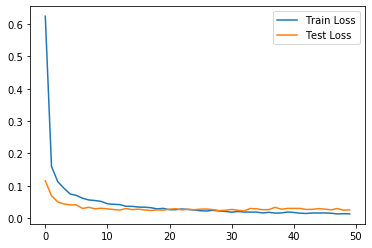

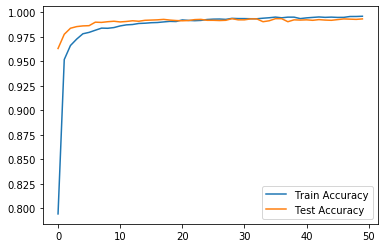

In [10]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss','Test Loss'])
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train Accuracy','Test Accuracy'])
plt.show()

Scoring a 99.3% test accuracy could be worse, but at least the number is around what you'd expect. I don't end up doing better than this, subsequently.

#### 2.b.2 Neural Correlates

It is interesting to note that the design of modern deep CNNs is loosely based on the human visual cortex, which is also arranged (to a first approximation) in feed-forward layers that evaulate progressively more abstract details in the image. Retinal input goes into V1, and then travels into ascending numerical layers:

<img src="https://i.stack.imgur.com/UvkCw.jpg" width="500">

Motion/spatial orientation vs labeling of image content is handled by two different pathways:

<img src="https://api.intechopen.com/media/chapter/39288/media/image1.png" width="300">

The temporal lobe is where auditory information is also processed and labeled, whereas the parietal lobe is closer to the motor cortices.

## 3. Things Tried and Failed

So after some extensive experimentation with batch normalization and image augmentation, I've mostly come to the conclusion that these additions are going to be too finnicky without hyperparameter tuning. Ensemble learning would likely help, but honestly MNIST isn't an interesting enough problem to really grind into dust, so I'll stop here.